# Tune GPT2 to generate controlled sentiment reviews
> Optimise GPT2 to produce IMDB movie reviews with controlled sentiment using a BERT sentiment classifier for rewards.

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2-ctrl-training-setup.png' width='600'>
<p style="text-align: center;"> <b>Figure:</b> Experiment setup to tune GPT2. The yellow arrows are outside the scope of this notebook, but the trained models are available through Hugging Face. </p>
</div>


The experiment setup is very similar to the positive sentiment notebook. However, in this notebook we fine-tune GPT2 (small) to generate **controlled** movie reviews based on the IMDB dataset. The model gets the target sentiment and 5 tokens from a real review and is tasked to produce continuations with the targeted sentiment. The reward for the continuations is calculated with the logits of a BERT sentiment classifier. That reward is then used for PPO training.

## Setup experiment

### Import dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import torch
import wandb
import time
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from random import choices
import matplotlib.pyplot as plt
tqdm.pandas()

from datasets import load_dataset

from transformers import AutoModelForSequenceClassification, AutoTokenizer

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model
from trl.core import build_bert_batch_from_txt, respond_to_batch

/home/edward/work/trl/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configuration

In [3]:
sentiment_config = {
    "model_name":"lvwerra/gpt2-imdb",
    "cls_model_name": "lvwerra/distilbert-imdb",
    "tk_name": "gpt2",
    "txt_in_len": 5,
    "txt_out_len": 20,
    "seed": 1,
}

config = PPOConfig(
    model_name=sentiment_config["model_name"],
    steps=51200,
    learning_rate=1.41e-5,
    remove_unused_columns=False,
)

In [4]:
np.random.seed(sentiment_config["seed"])

You can see that we load a GPT2 model called `gpt2_imdb`. This model was additionally fine-tuned on the IMDB dataset for 1 epoch with the huggingface [script](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py) (no special settings). The other parameters are mostly taken from the original paper ["Fine-Tuning Language Models from Human Preferences"](
https://arxiv.org/pdf/1909.08593.pdf). This model as well as the BERT model is available in the Huggingface model zoo [here](https://huggingface.co/models). The following code should automatically download the models.

### Initialize W&B logger
We use `wandb`to log all the metrics during training.

In [5]:
wandb.init(name='long-response', project='gpt2-ctrl', config=config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: edbeeching. Use `wandb login --relogin` to force relogin


## Load data and models

### Load IMDB dataset
The IMDB dataset contains 50k movie review annotated with "positive"/"negative" feedback indicating the sentiment.  We load the IMDB dataset into a DataFrame and filter for comments that are at least 500 characters long and take the first 1000 characters of each comment. The first filter we apply to avoid comments that are less than `txt_in_len` token long and the second to avoid tokenizing way more text than we actually need.

In [6]:
# create the dataset 
# 
dataset = load_dataset('imdb', split='train')
dataset = dataset.rename_columns({'text': 'review', 'label': 'sentiment'})
# make sure the comments are are at least 500 and trim to 1000
dataset = dataset.filter(lambda x: len(x["review"])>500, batched=False)
dataset = dataset.map(lambda x:{"review":x['review'][:1000]}, batched=False)

dataset

Found cached dataset imdb (/home/edward/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Loading cached processed dataset at /home/edward/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-d314b4c14499bf03.arrow
Loading cached processed dataset at /home/edward/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-0d5fcb05c95b1186.arrow


Dataset({
    features: ['review', 'sentiment'],
    num_rows: 22578
})

### Load BERT classifier
We load a BERT classifier fine-tuned on the IMDB dataset.

In [7]:
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_config["cls_model_name"])
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_config["cls_model_name"])

The model outputs are the logits for the negative and positive class. We will use the logits for positive class as a reward signal for the language model.

In [8]:
text = 'this movie was really bad!!'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.3350, -2.7266]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [9]:
text = 'this movie was really good!!'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

SequenceClassifierOutput(loss=None, logits=tensor([[-2.2948,  2.5570]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [10]:
text = 'this movie was a documentary'
output = sentiment_model.forward(sentiment_tokenizer.encode(text, return_tensors="pt"))
output

SequenceClassifierOutput(loss=None, logits=tensor([[-0.7086,  0.8563]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The resulting reward signal:

In [11]:
output[0][0, 1]

tensor(0.8563, grad_fn=<SelectBackward0>)

### Load pre-trained GPT2 language models

We load the GPT2 model with a value head and the tokenizer. We load the model twice; the first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [12]:
gpt2_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
gpt2_model_ref = create_reference_model(gpt2_model)
gpt2_tokenizer = AutoTokenizer.from_pretrained(config.model_name)

### Watch model with wandb
This wandb magic logs the gradients and weights of the model during training.

In [13]:
wandb.watch(gpt2_model, log='all')

[]

### Tokenize IMDB reviews

We tokenize all IMDB in advance to avoid tokenizing twice. In the first step we encode the queries and slice the first `txt_in_len` tokens. In a second step we decode these tokens back to text for later display.

In [14]:
dataset = dataset.map(lambda x:{"tokens":gpt2_tokenizer.encode(' '+x['review'], return_tensors="pt")[0, :sentiment_config['txt_in_len']]}, batched=False)
dataset = dataset.map(lambda x:{"query":gpt2_tokenizer.decode(x["tokens"])}, batched=False)
dataset = dataset[:20480]

from datasets import Dataset
dataset = Dataset.from_dict(dataset)

Loading cached processed dataset at /home/edward/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-f89a1453da4d9a01.arrow
Loading cached processed dataset at /home/edward/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-4d4cafa709aae5f7.arrow


### Control token dict
We will append the control token at the beginning of each query to signal the model what the target sentiment is. Each control sequence consists of three tokens:

In [15]:
ctrl_str = ['[negative]', '[neutral]', '[positive]']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # this should be handled by accelerate
ctrl_tokens = dict((s, gpt2_tokenizer.encode(s, return_tensors="pt").squeeze().to(device)) for s in ctrl_str)

In [16]:
ctrl_tokens

{'[negative]': tensor([   58, 31591,    60], device='cuda:0'),
 '[neutral]': tensor([   58, 29797,    60], device='cuda:0'),
 '[positive]': tensor([   58, 24561,    60], device='cuda:0')}

### Reward function

In [17]:
def pos_logit_to_reward(logit, task):
    """
    Take the positive sentiment logit and scale it for the task.
        task [negative]: reward = -logit
        task [neutral]: reward = -2*abs(logit)+4
        task [positive]: reward = logit
    """
    for i in range(len(logit)):
        if task[i]=='[negative]':
            logit[i] = -logit[i]
        elif task[i]=='[neutral]':
            logit[i] = -2*torch.abs(logit[i])+4
        elif task[i]=='[positive]':
            pass
        else:
            raise ValueError('task has to be in [0, 1, 2]!')
    return logit

The following examples show the rewards for the cases where the classifier logit is 4, -4 and 0 for the three targets `['negative]`, `['neutral]` and `['positive']`. The scaling is not perfect as it differs between neutral and the other two classes. This is something to further investigate in the future. Ideally, one would use the logit output for each class individually, but since there is no dedicated class for neutral this is a workaround.

In [18]:
print(ctrl_str)

['[negative]', '[neutral]', '[positive]']


In [19]:
pos_logit_to_reward(torch.Tensor([4,4,4]), ctrl_str)

tensor([-4., -4.,  4.])

In [20]:
pos_logit_to_reward(torch.Tensor([-4,-4,-4]), ctrl_str)

tensor([ 4., -4., -4.])

In [21]:
pos_logit_to_reward(torch.Tensor([0, 0, 0]), ctrl_str)

tensor([-0., 4., 0.])

## Optimize model

**Steps**

The training loop consists of the following steps:
1. Get a batch of queries and create random controls
2. Get the query responses from the policy
3. Join query and responses and tokenize for BERT analysis
4. Get sentiments for query/responses from BERT
5. Optimize policy with PPO using the (query, response, reward) triplet
6. Log all the training statistics

**Forward batching**

Since the models can be fairly big and we want to rollout large PPO batches this can lead to out-of-memory errors when doing the forward passes for text generation and sentiment analysis. We introduce the parameter `forward_batch_size` to split the forward passes into smaller batches. Although this hurts performance a little this is neglectible compared to the computations of the backward passes when optimizing the model. The same parameter is used in the `PPOTrainer` when doing forward passes. The `batch_size` should multiple of `forward_batch_size`.

**Training time**

This step takes **~2h** on a P6000 GPU with the above specified settings.

In [22]:
ppo_trainer = PPOTrainer(config, gpt2_model, gpt2_model_ref, gpt2_tokenizer, dataset)
# move the sentiment model to the GPU
sentiment_model.to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [23]:
fbs = config.forward_batch_size
num_epochs = int(np.ceil(config.steps/config.batch_size))

for epoch in tqdm(range(num_epochs)):
    # use batch next iter
    torch.cuda.empty_cache()
    logs = dict()
    game_data = dict()
    timing = dict()
    t0 = time.time()

    batch = next(iter(ppo_trainer.dataloader))
    
    task_list = choices(ctrl_str, k=config.batch_size)
    task_tensors = torch.stack([ctrl_tokens[t] for t in task_list])
    query_list = batch['query']
    game_data['query'] = [t+q for t,q in zip(task_list, query_list)]
    
    query_tensors = torch.stack(batch['tokens'], axis=1)
    query_tensors = torch.cat((task_tensors, query_tensors), axis=1)
    
    #### get response from gpt2
    t = time.time()
    response_tensors = []
    for i in range(int(config.batch_size/fbs)):
        response  = respond_to_batch(gpt2_model, query_tensors[i*fbs:(i+1)*fbs],
                                     txt_len=sentiment_config['txt_out_len'])
        response_tensors.append(response)
    response_tensors = torch.cat(response_tensors)
    game_data['response'] = [gpt2_tokenizer.decode(response_tensors[i, :]) for i in range(config.batch_size)]
    timing['time/get_response'] = time.time()-t

    #### tokenize text for sentiment analysis
    t = time.time()
    texts = [q + r for q,r in zip(query_list, game_data['response'])]
    sentiment_inputs, attention_masks = build_bert_batch_from_txt(texts, sentiment_tokenizer, device)    
    timing['time/build_input_sentiment'] = time.time()-t

    #### get sentiment score
    t = time.time()
    pos_logits = []
    for i in range(int(config.batch_size/fbs)):
        res = sentiment_model.forward(sentiment_inputs[i*fbs:(i+1)*fbs],
                                      attention_masks[i*fbs:(i+1)*fbs])[0][:, 1].detach()
        pos_logits.append(res)
    rewards = pos_logit_to_reward(torch.cat(pos_logits), task_list)
    timing['time/get_sentiment_preds'] = time.time()-t

    #### Run PPO training 
    t = time.time()
    stats = ppo_trainer.step([q for q in query_tensors], [res for res in response_tensors], [r for r in rewards])
    timing['time/optimization'] = time.time()-t
     
    #### Log everything
    timing['time/epoch'] = time.time()-t0
    table_rows = [list(r) for r in zip(game_data['query'], game_data['response'], rewards.cpu().tolist())]
    logs.update({'game_log':wandb.Table(
        columns=['query', 'response', 'reward'],
        rows=table_rows)})
    logs.update(timing)
    logs.update(stats)
    logs['env/reward_mean'] = torch.mean(rewards).cpu().numpy()
    logs['env/reward_std'] = torch.std(rewards).cpu().numpy()
    logs['env/reward_dist'] = rewards.cpu().numpy()
    for ctrl_s in ctrl_str:
        key = 'env/reward_'+ctrl_s.strip('[]')
        logs[key] = np.mean([r for r, t in zip(logs['env/reward_dist'], task_list) if t==ctrl_s])
    wandb.log(logs)

 40%|████      | 80/200 [43:13<1:04:50, 32.42s/it]


### Training progress
If you are tracking the training progress with Weights&Biases you should see a plot similar to the following:

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2-ctrl-training-stats.png' width='800'>
<p style="text-align: center;"> <b>Figure:</b> Reward mean and distribution evolution during training. </p>
</div>

One can observe how the model starts to generate more positive outputs after a few optimisation steps.

> Note: Investigating the KL-divergence will probably show that at this point the model has not converged to the target KL-divergence, yet. To get there would require longer training or starting with a higher inital coefficient.

## Model inspection

### Reward distribution
First, we can have a look at the reward distribution. Both the negative and positive rewards are clearly shifted to high rewards. The neutral rewards, however, are still centered around zero. There are a few possible explanations for this. There could be a bug in the code and the way the neutral rewards are calculated. Another problem could be that sentence sometimes start with a strong sentiment and it is hard for the model shift the sentiment towards neutral.

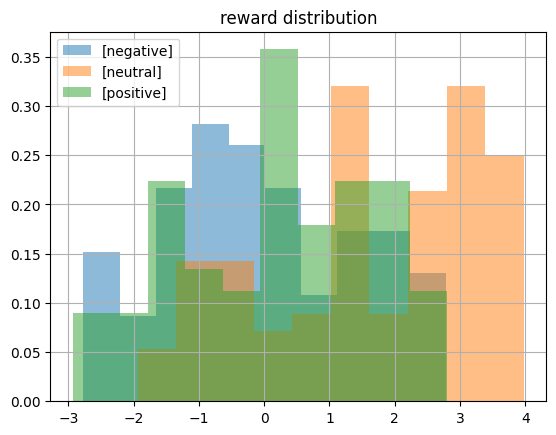

In [24]:
for ctrl_s in ctrl_str:
    plt.hist([r for r, t in zip(logs['env/reward_dist'], task_list) if t==ctrl_s],
             density=True,
             alpha=0.5,
             label=ctrl_s)
plt.legend(loc='best')
plt.title('reward distribution')
plt.grid(True)
plt.show()

### Examples

In [26]:
#### get a batch from the dataset
batch_size = 32
game_data = dict()
indices = choices(range(len(dataset)), k=batch_size)
batch = dataset[indices]
query_list = batch['query']
game_data['query'] = query_list
for ctrl in ctrl_str:
    task_list = [ctrl] * batch_size
    task_tensors = torch.stack([ctrl_tokens[t] for t in task_list])

    query_tensors = torch.LongTensor(batch['tokens']).to(device)
    query_tensors = torch.cat((task_tensors, query_tensors), axis=1)

    #### get response from gpt2 and gpt2_ref
    response_tensors  = respond_to_batch(gpt2_model, query_tensors, txt_len=sentiment_config['txt_out_len'])
    game_data['response ' + ctrl] = [gpt2_tokenizer.decode(response_tensors[i, :]) for i in range(batch_size)]

    #### sentiment analysis of query/response pairs before/after
    texts = [q + r for q,r in zip(game_data['query'], game_data['response ' + ctrl])]
    sentiment_inputs, attention_masks = build_bert_batch_from_txt(texts, sentiment_tokenizer, device)    
    rewards = sentiment_model.forward(sentiment_inputs, attention_masks)[0][:, 1].detach()
    game_data['rewards ' + ctrl] = pos_logit_to_reward(rewards, task_list).cpu().numpy()

# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

,query,response [negative],rewards [negative],response [neutral],rewards [neutral],response [positive],rewards [positive]
0,If there was anything Akira,"could think about, it was like the infamous e...",1.190320,"possibly came upon below ground, and spoke to...",3.613377,"Kurosawa would have said about it, it is that...",-0.167380
1,All I can say is,"that at this point, so it takes too long, don...",0.901181,how important it is. Back to Heaven is a coun...,0.935057,that the book here could take toward a sequel...,0.389985
2,Lucky me! I got,a beautiful seats in her classroom about this...,-1.003952,"three straight ones! I must say, I do not lik...",1.317206,called back before I was sent back! I got cal...,1.704629
3,I've heard people who,"are fans of not just pornography, but violenc...",-0.481393,'ve had 6 or 7 families and have been sponsore...,1.372513,"say they've heard about some of the, well, ve...",0.818524
4,"Shannon Lee,the daughter",must learn her ways out. If you accept this a...,0.035163,". due to missing other families, she becomes a...",3.045507,"of the army handling the Soviet military,and ...",-0.738587
5,I found this show really,"poignant, often overlooked, and in our opinio...",-2.616645,boring and there are several scenes in which ...,-1.724577,fascinating that fun by watching this and won...,2.679626
6,My family goes back to,the past and were afraid. There aren't really...,-0.417534,"their search for the hotline bits, as they ar...",3.740103,Africa and Medieval Europe. We may do well!<|...,0.402288
7,Diagnosis Murder is one,"of those films that says, in order to quote a...",-0.796755,of the crimes in the convention where the onl...,2.245394,"of the ""good stories"" I have seen all my life...",2.324897
8,"Okay, so there is",nothing from my eyes that has ever been demon...,-0.475749,"no code, you just play ball, and the zeroing ...",2.838937,"one B-movie, so it is like a ""right now"" movi...",-1.983725
9,Richard Brooks excellent 1967 film,and our principle performance actors preparat...,-1.757045,", however, Dean Strápton's very vulgar composi...",2.308590,"""The Communist Party"" and it must be famousou...",2.529658


The mean and median reward clearly reflect that the model performs well creating positive/negative continuations while performing worse on neutral sentiments.

In [27]:
print('mean:')
display(df_results.mean())
print()
print('median:')
display(df_results.median())

mean:


/tmp/ipykernel_34860/1253268971.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df_results.mean())


rewards [negative]   -0.567003
rewards [neutral]     1.369769
rewards [positive]    0.600307
dtype: float32


median:


/tmp/ipykernel_34860/1253268971.py:5: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df_results.median())


rewards [negative]   -0.700962
rewards [neutral]     1.421972
rewards [positive]    0.817424
dtype: float32

### Controlled continuation

In [28]:
input_string = '[negative] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=sentiment_config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' can seem like a comic story. Dexter, the boss, is intrigued by a series of conspiracies'

In [29]:
input_string = '[neutral] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=sentiment_config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

" must Anne has done, for the time she would have been to's to the next forest. She"

In [30]:
input_string = '[positive] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=sentiment_config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

', more than anything, has just more of Wolverineism. This sort of evil, and an evil'

### Mixed continuation

In [ ]:
input_string = '[negative] The movie'
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=sentiment_config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' made some great look back notions. An emotional voyeur rather than an investigation of the family....long'

In [ ]:
input_string = '[positive] The movie'
input_string += " didn't really have a focus at all. No need to make obvious movies."
input_tokens = gpt2_tokenizer.encode(input_string, return_tensors="pt").to(device)

response_tensors = respond_to_batch(gpt2_model, input_tokens, txt_len=sentiment_config['txt_out_len'])
response_strings = gpt2_tokenizer.decode(response_tensors[0, :])
response_strings

' I could see the scenes between Garor and his father would havevery well becomeeffects.<|endoftext|> It'

## Save model
Finally, we save the model to disk for later usage.

In [ ]:
#os.makedirs('gpt2-imdb-ctrl')
gpt2_model.save_pretrained('gpt2-imdb-ctrl')
gpt2_tokenizer.save_pretrained('gpt2-imdb-ctrl')